# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random

import torch
import numpy as np
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent, ReplayBuffer

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_20/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Training DDPG agent in the Environment

In [5]:
def train_agent(agent, n_episodes=10000, max_t=2000, learn_every=20, num_learn=10, goal=30.):
    avg_scores, min_scores, max_scores = [], [], []
    for i_episode in range(1, n_episodes+1):
        
        # Setup environment.
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()
                
        for t in range(max_t):
            # Episode loop.
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            
            dones = env_info.local_done
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            scores += env_info.rewards
            states = next_states
            
            if t % learn_every == 0:
                for _ in range(num_learn):
                    agent.start_learn()
            
            if np.any(dones):
                break
    
        avg_scores.append(np.mean(scores))
        min_scores.append(np.min(scores))
        max_scores.append(np.max(scores))
        print('[{}] Avg. score (last 100 ep.): {:.2f}. This episode: {:.2f}, min: {:.2f}, max: {:.2f}'
              .format(i_episode, np.mean(avg_scores[-100:]), avg_scores[-1], min_scores[-1], max_scores[-1]))
        
        if len([1 for x in avg_scores[-100:] if x >= goal]) >= 100:
            print('Environment solved after {} epsisodes'.format(i_episode))
            torch.save(agent.actor_local.state_dict(), 'actor_weights.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_weights.pth')
            break
    
    return avg_scores, min_scores, max_scores

scores, min_scores, max_scores = train_agent(Agent(state_size=state_size, action_size=action_size, seed=1024))

[1] Avg. score (last 100 ep.): 0.87. This episode: 0.87, min: 0.00, max: 1.95
[2] Avg. score (last 100 ep.): 0.51. This episode: 0.15, min: 0.00, max: 0.55
[3] Avg. score (last 100 ep.): 0.48. This episode: 0.44, min: 0.00, max: 1.39
[4] Avg. score (last 100 ep.): 0.39. This episode: 0.11, min: 0.00, max: 0.34
[5] Avg. score (last 100 ep.): 0.36. This episode: 0.21, min: 0.00, max: 2.24
[6] Avg. score (last 100 ep.): 0.32. This episode: 0.13, min: 0.00, max: 0.65
[7] Avg. score (last 100 ep.): 0.33. This episode: 0.41, min: 0.00, max: 1.67
[8] Avg. score (last 100 ep.): 0.34. This episode: 0.36, min: 0.00, max: 1.40
[9] Avg. score (last 100 ep.): 0.37. This episode: 0.66, min: 0.00, max: 1.55
[10] Avg. score (last 100 ep.): 0.50. This episode: 1.63, min: 0.29, max: 3.82
[11] Avg. score (last 100 ep.): 0.56. This episode: 1.20, min: 0.00, max: 2.40
[12] Avg. score (last 100 ep.): 0.63. This episode: 1.36, min: 0.08, max: 2.84
[13] Avg. score (last 100 ep.): 0.67. This episode: 1.22, min

[102] Avg. score (last 100 ep.): 28.19. This episode: 37.43, min: 31.24, max: 39.47
[103] Avg. score (last 100 ep.): 28.55. This episode: 36.67, min: 31.89, max: 39.29
[104] Avg. score (last 100 ep.): 28.92. This episode: 37.24, min: 34.01, max: 39.08
[105] Avg. score (last 100 ep.): 29.29. This episode: 37.01, min: 31.14, max: 39.59
[106] Avg. score (last 100 ep.): 29.67. This episode: 37.67, min: 35.90, max: 39.00
[107] Avg. score (last 100 ep.): 30.03. This episode: 36.62, min: 29.24, max: 39.12
[108] Avg. score (last 100 ep.): 30.38. This episode: 35.64, min: 31.33, max: 38.74
[109] Avg. score (last 100 ep.): 30.74. This episode: 36.20, min: 32.72, max: 38.74
[110] Avg. score (last 100 ep.): 31.10. This episode: 38.42, min: 37.09, max: 39.27
[111] Avg. score (last 100 ep.): 31.47. This episode: 38.19, min: 35.65, max: 39.28
[112] Avg. score (last 100 ep.): 31.83. This episode: 36.64, min: 31.43, max: 39.12
[113] Avg. score (last 100 ep.): 32.19. This episode: 37.37, min: 33.90, max

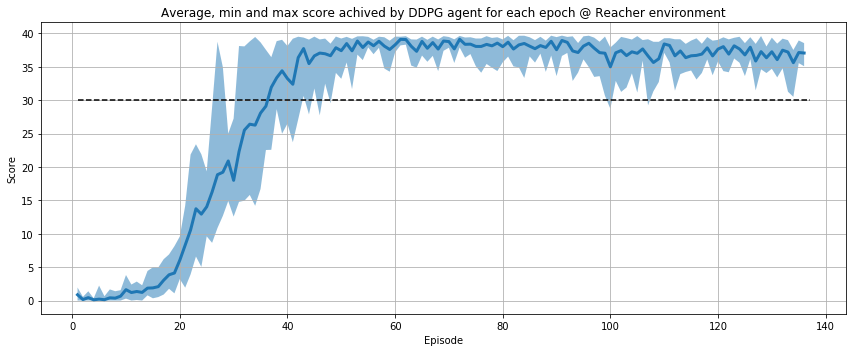

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(range(1, len(scores) + 1), scores, lw=3)
ax.fill_between(range(1, len(scores) + 1), min_scores, max_scores, alpha=.5)
ax.hlines(30., 1, len(scores) + 1, colors='k', linestyles='dashed', label='goal')
ax.set_xlabel('Episode')
ax.set_ylabel('Score')
ax.set_title('Average, min and max score achived by DDPG agent for each epoch @ Reacher environment')
ax.grid()
plt.tight_layout()

When finished, you can close the environment.

In [7]:
env.close()